<a href="https://colab.research.google.com/github/airinrs/Garbage-classification/blob/main-2/Copy_of_combined_CVNLP_Assignment1_airin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **CVNLP Assignment - Garbage Classification**


---



Line wrapping for viewing purposes only

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## **Importing Essential Libraries**

In [ ]:
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

from IPython.display import display

## **Loading Dataset**

### Option 1: Loading and extracting manually from zip file

In [ ]:
# This is for uploading our datasets zip file
uploaded = files.upload()

In [ ]:
# The below codes are directories for getting our zip files stored into colab
zip_path = '/content/garbage_classification.zip'  # Path to the uploaded zip file
extract_path = '/content/gdrive/MyDrive/garbage_classification'  # Where you want to extract the files

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the data directory path for further processing
data_dir = extract_path

print(f"Data directory: {data_dir}")

### Option 2: Loading from Google Drive

Mounting notebook to Google Drive

In [ ]:
import io
import requests
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [ ]:
data_dir = "/content/gdrive/MyDrive/garbage_classification"

# This is to check whether we extracted our dataset successfully
if os.path.exists(data_dir):
    print("Directory exists!")
    print("Contents:", os.listdir(data_dir))
else:
    print("Directory does not exist. Check the path.")

Directory exists!
Contents: ['garbage_classification']


In [ ]:
# Load data paths and identiy the number of classes in the dataset
data_dir = '/content/gdrive/MyDrive/garbage_classification/garbage_classification'
classes = os.listdir(data_dir)
print(f'classes found : [{classes}]')
data = []

for label in classes:
    folder_path = os.path.join(data_dir, label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        data.append([img_path, label])

# Convert to DataFrame
image_df = pd.DataFrame(data, columns=['image_path', 'label'])

classes found : [['Battery', 'Paper', 'Paperboard', 'Plastic', 'Glass', 'metal', 'Organic']]


In [ ]:
# This is simply go-through for the content of our dataset
for root, dirs, files in os.walk(data_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("----------")

print(data_dir)


Root: /content/gdrive/MyDrive/garbage_classification/garbage_classification
Directories: ['Battery', 'Paper', 'Paperboard', 'Plastic', 'Glass', 'metal', 'Organic']
Files: []
----------
Root: /content/gdrive/MyDrive/garbage_classification/garbage_classification/Battery
Directories: []
Files: ['battery1.jpg', 'battery10.jpg', 'battery100.jpg', 'battery101.jpg', 'battery102.jpg', 'battery103.jpg', 'battery104.jpg', 'battery105.jpg', 'battery106.jpg', 'battery107.jpg', 'battery108.jpg', 'battery109.jpg', 'battery11.jpg', 'battery110.jpg', 'battery111.jpg', 'battery112.jpg', 'battery113.jpg', 'battery114.jpg', 'battery115.jpg', 'battery116.jpg', 'battery117.jpg', 'battery118.jpg', 'battery119.jpg', 'battery12.jpg', 'battery120.jpg', 'battery121.jpg', 'battery122.jpg', 'battery123.jpg', 'battery124.jpg', 'battery125.jpg', 'battery126.jpg', 'battery127.jpg', 'battery128.jpg', 'battery129.jpg', 'battery13.jpg', 'battery130.jpg', 'battery131.jpg', 'battery132.jpg', 'battery133.jpg', 'battery134

### View sample dataset images

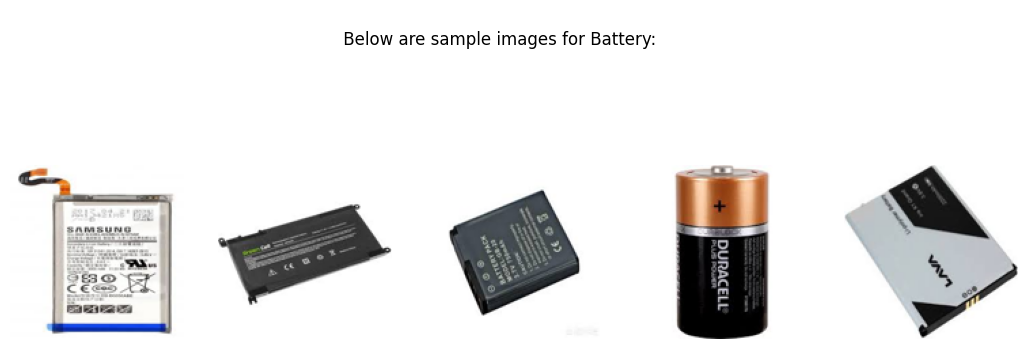

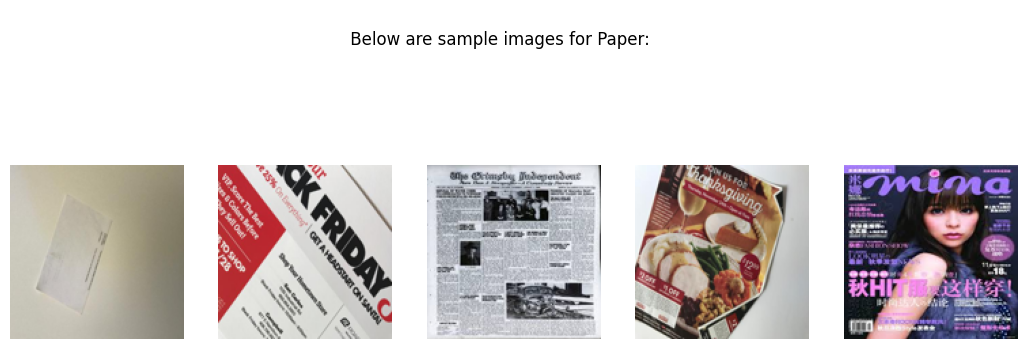

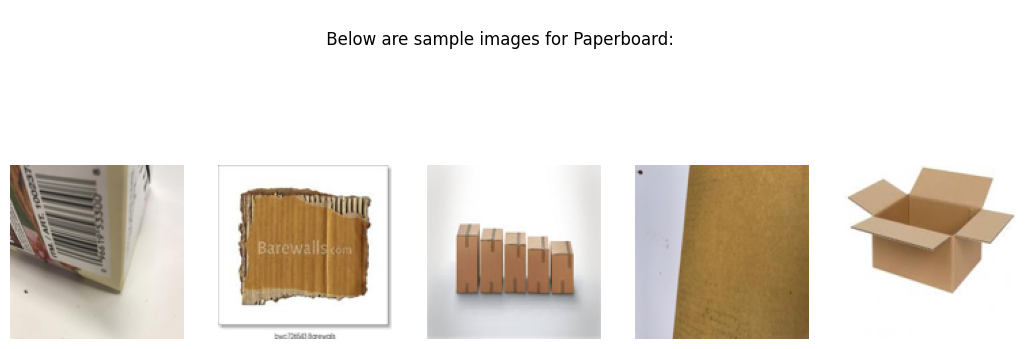

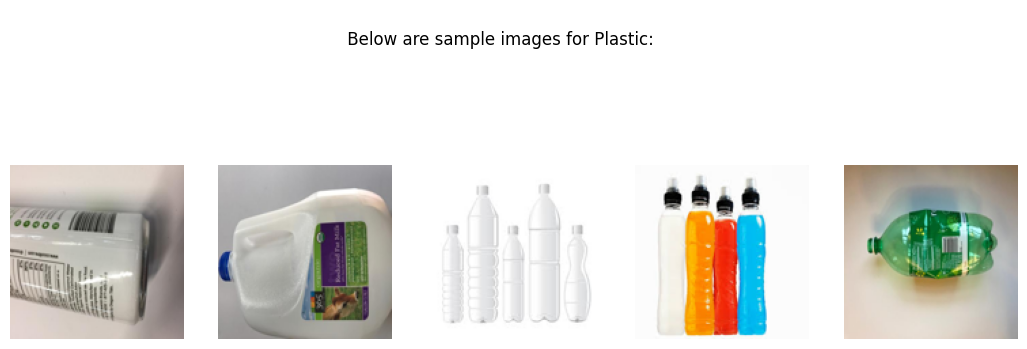

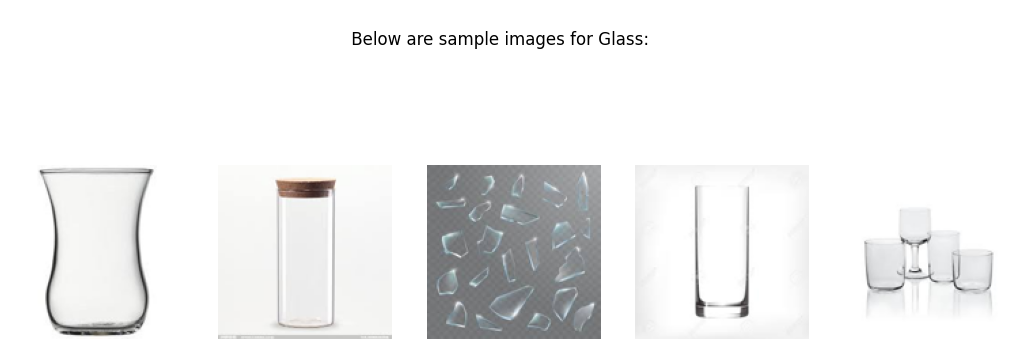

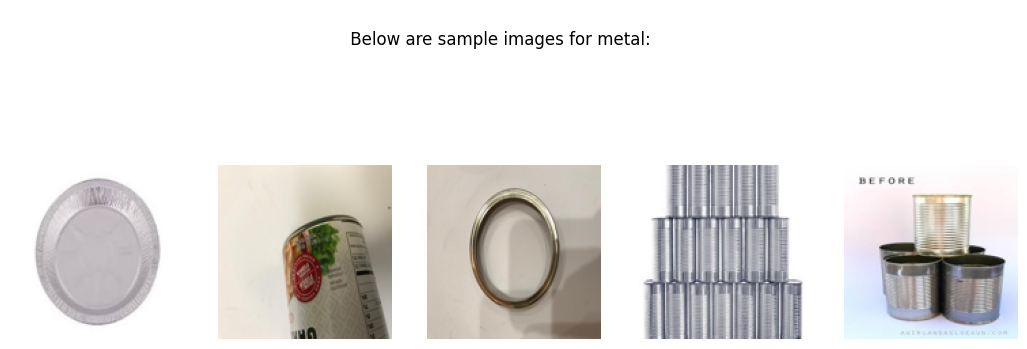

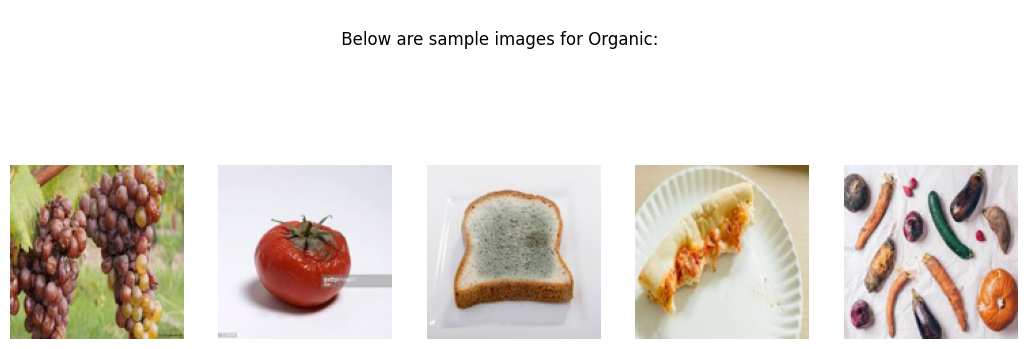

In [ ]:
# Load and resize sample images
def load_image(path, size=(128, 128)):
    img = Image.open(path)
    img = img.resize(size)
    return np.array(img)

# Show some sample images
for label in classes:
    plt.figure(figsize=(13,5))
    plt.suptitle(f'\n Below are sample images for {label}:')
    sample_images = image_df[image_df['label'] == label]['image_path'].sample(5)
    for i, img_path in enumerate(sample_images):
        plt.subplot(1, 5, i+1)
        img = load_image(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

## **Data Preprocessing and Explorative Data Analysis (EDA)**

### Removing any missing data

In [ ]:
# Remove for any missing values in the dataframe

image_df.dropna(subset=['image_path'], inplace=True)
print(image_df.isnull().sum())

image_path    0
label         0
dtype: int64


### Barchart for class distribution

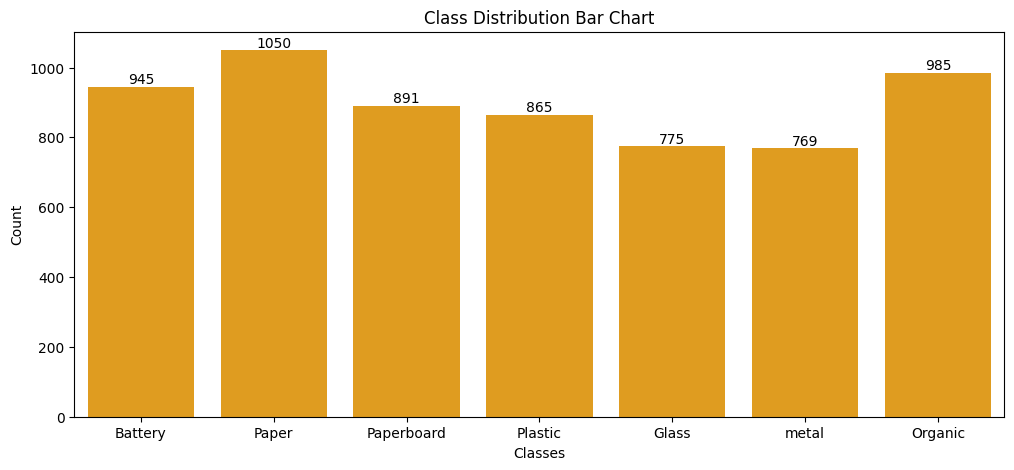

In [ ]:
# plot barchart of image class distribution
plt.figure(figsize=(12, 5))
sns.countplot(x='label', data=image_df, color= 'orange')
plt.title('Class Distribution Bar Chart')
plt.bar_label(plt.gca().containers[0])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


### Pie chart for class distribution

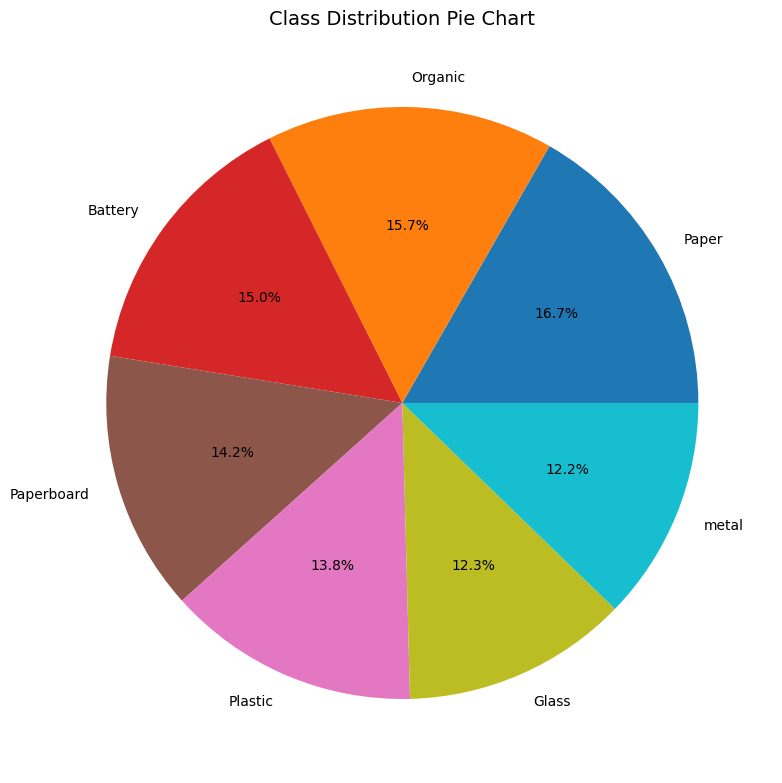

In [ ]:
# plot pie chart of image class distribution
class_counts = image_df['label'].value_counts()
plt.figure(figsize=(8, 8))
class_counts.plot.pie(cmap='tab10', autopct='%1.1f%%',legend=False)
plt.title('Class Distribution Pie Chart', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

# **Data Splitting**

Split the dataframe into Training, Validation, and Testing dataframes

In [ ]:
# Shuffle the dataset
image_df = shuffle(image_df, random_state=42)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(image_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 10% test, 20% val

# Check splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 4396
Validation set size: 1262
Test set size: 622


# **Data Augmentation**

In [ ]:
# This is Data Augmentation
# improve model generalization by creating variations of existing images)
# creates variations (e.g., rotated, flipped, or zoomed versions)of images
# during each batch but doesn't permanently increase the dataset size.

# Augmnent training data with rotation, zooming, flipping, etc.
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=20,             # Rotate images by up to 20 degrees
    zoom_range=0.15,                # Randomly zoom in
    horizontal_flip=True,          # Flip images horizontally
    fill_mode='nearest'            # Fill empty pixels with nearest values
)

# No augmentation for validation and test data, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators for train, test, val dataframes
print("Training set:")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
print("\nValidation set:")
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
print("\nTesting set:")
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Training set:
Found 4396 validated image filenames belonging to 7 classes.

Validation set:
Found 1262 validated image filenames belonging to 7 classes.

Testing set:
Found 622 validated image filenames belonging to 7 classes.


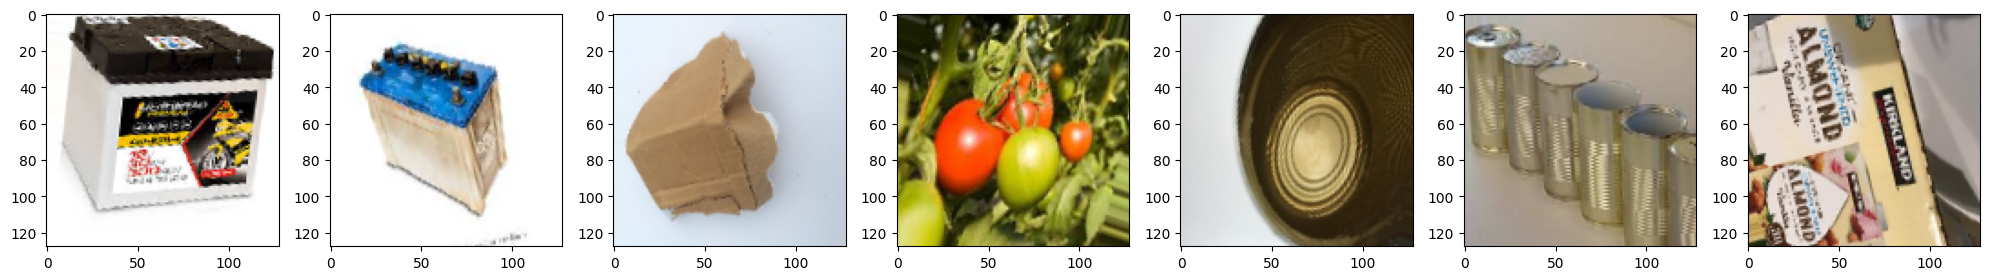

In [ ]:
#REFERENCE: Aenori/ECE_public (suggested by colab)
# -----------------------------------------------------------------------------

#show sample augmented images from the training dataset (trainData)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#show random training images
sample_training_images, _ = next(train_generator)
random_indices = np.random.choice(sample_training_images.shape[0], size=10, replace=False)
random_images = sample_training_images[random_indices]
plotImages(random_images)

# **Model Architecture Designing and Implementation**

## Designing the model architecture

In [ ]:
# CNN layer architecture configurations:
# 3 convolutional layers, 3 max pooling layers,
# 1 globalaveragepooling layer, 1 dropout layer, 2 dense layers

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # removed flatten instead use GlobalAvgPooling
    GlobalAveragePooling2D(),
    # Automatically adjusts the size(to  match the input size of dense layer)

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,663 (432.28 KB)

 Trainable params: 110,663 (432.28 KB)

 Non-trainable params: 0 (0.00 B)

## Visualise the model architecture

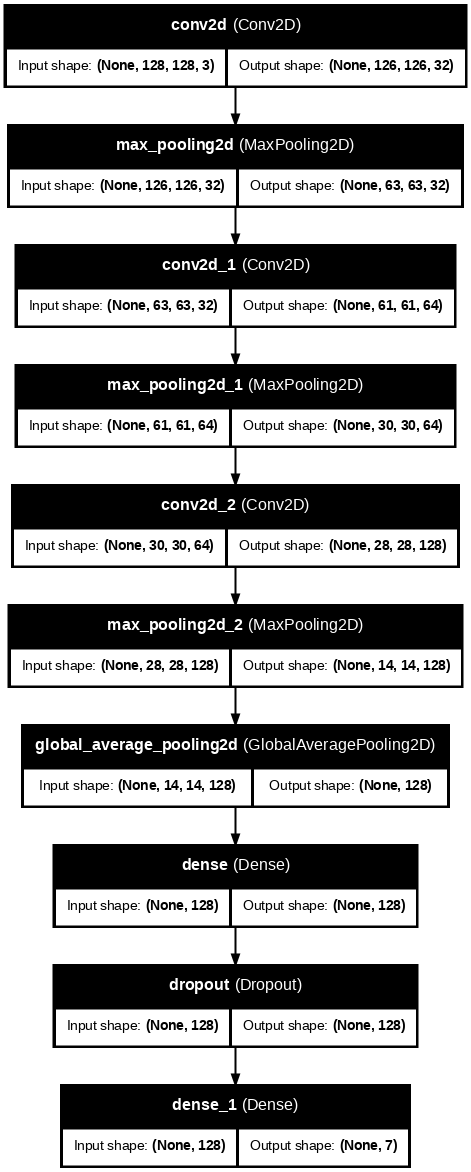

In [ ]:
# plot the model layers
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_architecture.png',
    dpi=72  #smaller size
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 39.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


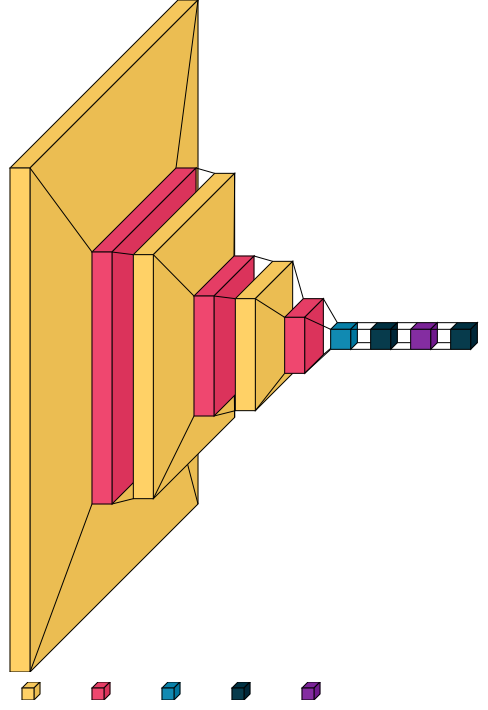

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, spacing = 20, legend = True)



# **Model Training**

### Compile model

In [ ]:
#compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Fit model for training

In [ ]:
#fit model for training

early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model.fit(
  train_generator,
  epochs=60,
  validation_data=val_generator,
  callbacks = early_stopping,
  verbose=1
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 1052s 7s/step - accuracy: 0.2636 - loss: 1.7841 - val_accuracy: 0.4366 - val_loss: 1.4842
Epoch 2/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4338 - loss: 1.4490 - val_accuracy: 0.4873 - val_loss: 1.3256
Epoch 3/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4994 - loss: 1.3302 - val_accuracy: 0.4414 - val_loss: 1.4510
Epoch 4/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5245 - loss: 1.2608 - val_accuracy: 0.5380 - val_loss: 1.2348
Epoch 5/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5645 - loss: 1.1822 - val_accuracy: 0.5420 - val_loss: 1.1913
Epoch 6/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5617 - loss: 1.2074 - val_accuracy: 0.5571 - val_loss: 1.1430
Epoch 7/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5788 - loss: 1.1392 - val_accuracy: 0.6030 - val_loss: 1.0917
Epoch 8/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6007 - loss: 1.0851 - val_accuracy: 0.58

# **Model Evaluation and Metrics**

### Plot model accuracy over epochs

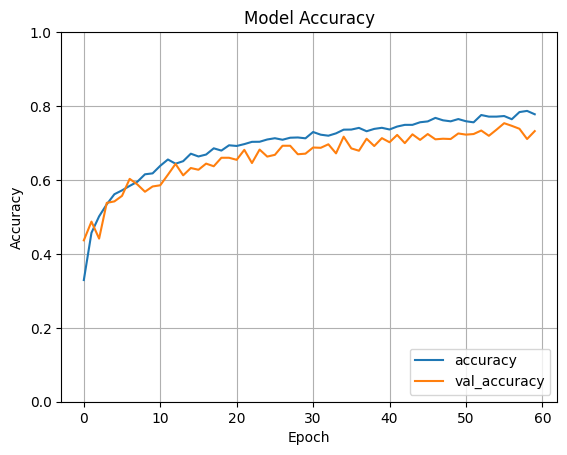

In [ ]:
# plot the trend of epoch histories
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Plot model loss over epochs

Text(0.5, 1.0, 'Model Loss')

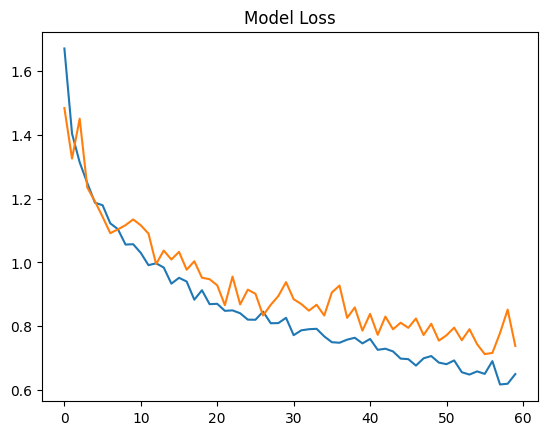

In [ ]:
# plot training loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')

## Model Prediction and Evaluation

### Model training, validation, and testing accuracies

In [ ]:
# evaluate overall model training accuracy
train_loss, train_accuracy = model.evaluate(train_generator)
train_accuracy = round(train_accuracy, 3)
print(f'Train Accuracy: {train_accuracy}')


138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 593ms/step - accuracy: 0.8198 - loss: 0.5242
Train Accuracy: 0.819


In [ ]:
# evaluate overall model validation accuracy
val_loss, val_accuracy = model.evaluate(val_generator)
val_accuracy = round(val_accuracy, 3)
print(f'Validation Accuracy: {val_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7591 - loss: 0.6931
Validation Accuracy: 0.754


In [ ]:
# evaluate overall model testing accuracy
test_true = test_generator.classes
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_loss, test_accuracy = model.evaluate(test_generator)

test_accuracy = round(test_accuracy, 3)
print(f'Test Accuracy: {test_accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.7660 - loss: 0.6864
Test Accuracy: 0.749


### Classification Report

In [ ]:
# classification report
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_true, test_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Battery       0.78      0.82      0.80       106
       Glass       0.69      0.44      0.54        75
     Organic       0.91      0.80      0.85       102
       Paper       0.70      0.89      0.78       104
  Paperboard       0.81      0.88      0.84        88
     Plastic       0.70      0.67      0.69        73
       metal       0.61      0.61      0.61        74

    accuracy                           0.75       622
   macro avg       0.74      0.73      0.73       622
weighted avg       0.75      0.75      0.74       622



### Confusion matrix

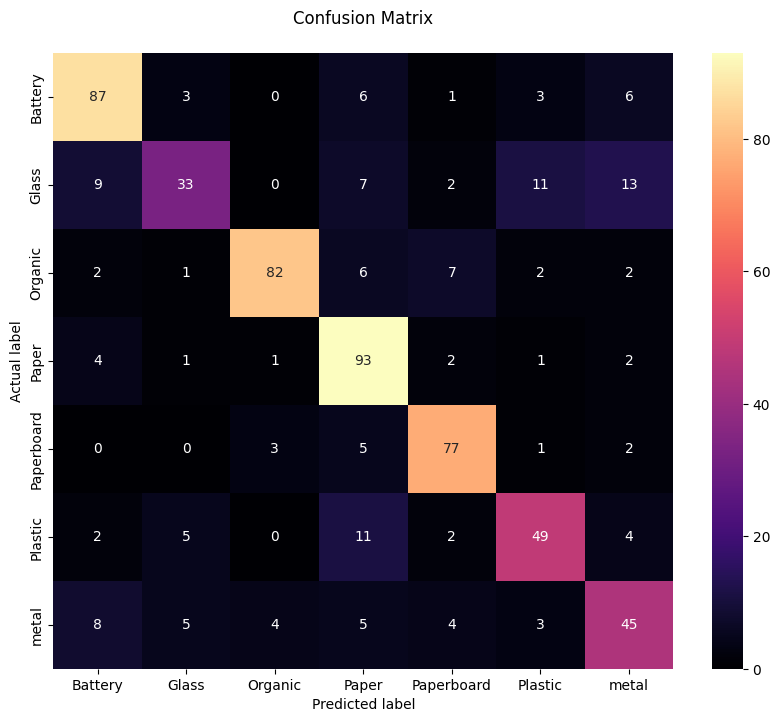

In [ ]:
# confusion matrix
conf_m = confusion_matrix(test_true, test_pred_classes)
plt.figure(figsize=(10, 8))           #colourful!!!!
sns.heatmap(conf_m, annot=True, fmt='d', cmap='magma', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix\n')
plt.show()

Accuracy for Battery class: 82.08%
Accuracy for Glass class: 44.00%
Accuracy for Organic class: 80.39%
Accuracy for Paper class: 89.42%
Accuracy for Paperboard class: 87.50%
Accuracy for Plastic class: 67.12%
Accuracy for metal class: 60.81%


Text(0.5, 1.0, 'Accuracy of Each Class')

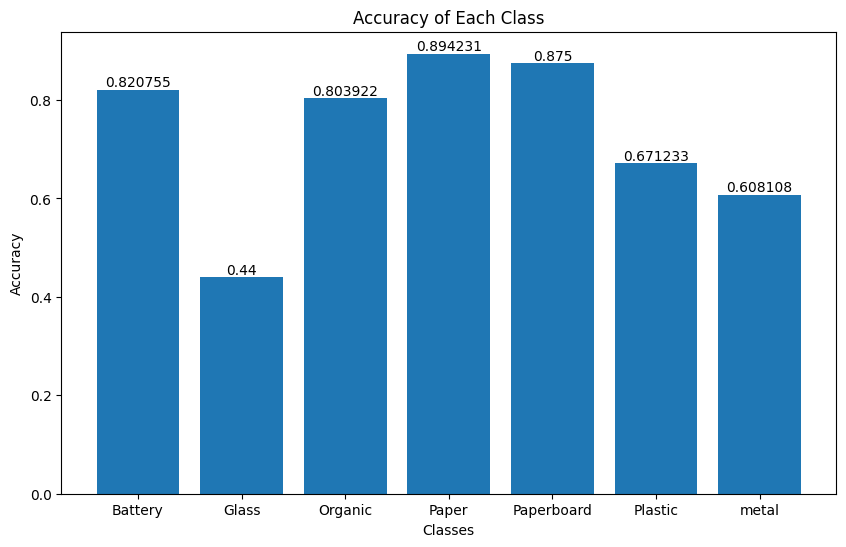

In [ ]:
#REFERENCE = https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html
#REFERENCE = https://stackoverflow.com/questions/56084882/how-to-show-precision-in-a-confusion-matrix
#-------------------------------------------------------------------------------

#accuracy of each class (a.k.a. recall)
class_accuracy = (np.diag(conf_m) / np.sum(conf_m, axis=1))
for i, class_name in enumerate(target_names):
    print(f'Accuracy for {class_name} class: {class_accuracy[i]:.2%}')

#plot the bar chart for the accuracy of each class
plt.figure(figsize=(10, 6))
plt.bar(target_names, class_accuracy)
plt.bar_label(plt.gca().containers[0])
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Class')

### Model Prediction

A test to classify a sample image from dataset

Paperboard class

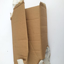

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
The predicted class is: Paperboard


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Paperboard/cardboard891.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Plastic class

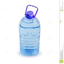

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
The predicted class is: Plastic


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Plastic/plastic848.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Organic class

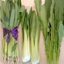

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The predicted class is: Organic


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Organic/biological975.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Metal class

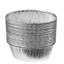

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The predicted class is: metal


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/metal/metal766.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Paper class

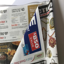

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
The predicted class is: Paper


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Paper/paper1025.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Battery class

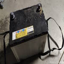

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
The predicted class is: Battery


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Battery/battery932.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")

Glass class

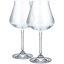

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
The predicted class is: Glass


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "/content/gdrive/MyDrive/garbage_classification/garbage_classification/Glass/white-glass750.jpg"
img = Image.open(image_path).resize((64, 64))  # Resize to match model input size
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
display(img)

# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print the prediction
print(f"The predicted class is: {class_labels[predicted_class]}")